In [1]:
from pipeline.data_access.dao.sussex_huawei_dao import SussexHuaweiDAO
from pipeline.feature_engineering.preprocessing.sussex_huawei_preprocessor import SussexHuaweiPreprocessor
from pipeline.feature_engineering.feature_extraction.baseline_extractor import BaselineExtractor
from pipeline.machine_learning.model.sklearn_model_factory import SklearnModelFactory
from pipeline.machine_learning.model.tslearn_model_factory import TslearnModelFactory
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas
import pickle
import numpy as np
from scipy.stats import randint as sp_randint
import gc

In [2]:
# 0. Initialize Pipeline Objects (TODO: Put into a pipleine Facade)
dao = SussexHuaweiDAO()
preprocessor = SussexHuaweiPreprocessor()
extractor = BaselineExtractor()
tslearn_factory, sklearn_factory = TslearnModelFactory(),  SklearnModelFactory()

In [22]:
# 1. Load Data
data_column_names = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', #TODO: Pack in config/.env
                             #'a', 'b', 'c', 'd', 'e', 'f',
                             'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z',
                             'l_acceleration_x', 'l_acceleration_y', 'l_acceleration_z',
                             
                             ]
label_column_names = ['coarse_label', 'fine_label', 'road_label']

#bad trips: 310517, 260417, 200617, 160517, 150317, 090517, 050517
trips = [
        '010317', '010617', '020317', 
        '020517', '020617', '030317', '030517', '030617', '030717',
        '040517', '040717', '050617', '050717', '060317', '060617',
        '070317', '070617', '080317', '080517', '080617', '090317', 
        '090617', '100317', '100517', '110517', '120517', '120617',
        '130317', '130617', '140317', '140617', '150517', '150617', 
        '160317', '170317', '170517', '180417', '190417', '190517',
        '200317', '200417', '200517', '210317', '220317', '220517', 
        '220617', '230317', '230517', '230617', '240417', '240517', 
        '250317', '250417', '250517', '260517', '260617', '270317',
        '270417', '270617', '280317', '280417', '280617', '290317',
        '290517', '290617', '300317', '300517', '300617'
]

#trips = random.sample(trips, len(trips)//2)

data_string = "./data_sets/sussex_huawei/User1/{}/Hips_Motion.txt"
label_string = "./data_sets/sussex_huawei/User1/{}/Label.txt"
use_data_cols = [0,1,2,3, #4,5,6,7,8,9,
                 10,11,12,13,14,15,16,
                 17,18,19
                ]#4,5,6,7,8,9,17,18,19
#use_data_cols = [0,17,18,19,
                 #10,11,12,13,14,15,16
#                ]#4,5,6,7,8,9,17,18,19
use_label_cols = [1, 2, 3]

labels, data = dao.bulk_read_data(
    file_path=[
        data_string,
        label_string
    ],
    identifiers=trips,
    column_names=[
        data_column_names,
        label_column_names
    ],
    use_columns=[
        use_data_cols,
        use_label_cols
    ]
)


In [23]:
# 2. Preprocessing
# 2.1 Convert unix time (ms) to date time
data = preprocessor.convert_unix_to_datetime(data, column = 'time', unit = 'ms')

In [24]:
# 2.2 Label data and remove NaNs
data = preprocessor.label_data(data, labels)
data = preprocessor.remove_nans(data, replacement_mode='del_row')

In [3]:
# 2.3 Normalization
acelerometer_columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gravity_columns = ['gravity_x', 'gravity_y', 'gravity_z']
orientation_columns = ['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']

#only used for motif discovery in n-d TS
#data = preprocessor.project_accelerometer_to_global_coordinates(
#            data, 
#            mode ='orientation', 
#            target_columns = acelerometer_columns,
#            args = orientation_columns)


#only used for motif discovery in n-d TS
#data = preprocessor.project_accelerometer_to_global_coordinates(
#            data, 
#            mode ='gravity', 
#            target_columns = acelerometer_columns,
#           args = gravity_columns)

#data = preprocessor.znormalize_quantitative_data(data, data_column_names[1:])
#data = preprocessor.min_max_normalize_quantitative_data(data, data_column_names[1:])
#print(data.shape)

In [26]:
# 2.4 Segment data
# Coarse Label: Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
# Road Label: City=1, Motorway=2, Countryside=3, Dirt road=4, Null=0
selected_coarse_labels = [5]
selected_road_labels = [1, 3]
car_segments = preprocessor.segment_data(data, mode='labels', 
                                 label_column='coarse_label', 
                                 args=selected_coarse_labels)

#print(car_segments)
data_segments = []
for car_segment in car_segments:
        road_segments = preprocessor.segment_data(car_segment, mode='labels', 
                                  label_column='road_label',
                                  args=selected_road_labels
                                )
        for road_segment in road_segments:
            data_segments.append(road_segment)   
            

In [27]:
# Store before filtering for later experimenting with different filters
print(len(data_segments))
import pickle
with open('./tmp_segments', 'wb') as segments_file:
    pickle.dump(data_segments, segments_file)

158


In [4]:
import pickle
with open('./tmp_segments', 'rb') as segments_file:
    data_segments = pickle.load(segments_file)
print(len(data_segments))

158


In [5]:
# 2.5 Low Pass filtering -> #100 Hz to 10 Hz
for ind in range(len(data_segments)):
    data_segments[ind] = data_segments[ind].set_index('time')
    data_segments[ind] = preprocessor.resample_quantitative_data(data_segments[ind], 
                                                                 freq='1000ms') #8000 1.25 Hz
    #1000ms 10 hz used for tsfresh

In [6]:
#for segment in data_segments:
    #print(len(segment))

In [7]:
#2.6 Outlier removal:
#for ind in range(len(data_segments)):
#    data_segments[ind] = preprocessor.remove_outliers_from_quantitative_data(
#        data_segments[ind],
#        replacement_mode = 'quantile',
#        columns = acelerometer_columns,
#        quantile = 0.95 #current run @0.95 for classical approach via TS Fresh
#    )

In [8]:
# 2.7 Dimensionality reduction:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.reduce_quantitativ_data_dimensionality(
                data = data_segments[ind],
                mode ='euclidean', #works better than euclidean for motif
                columns = acelerometer_columns,
                reduced_column_name = 'acceleration_abs'
            )
    
    #data_segments[ind] = preprocessor.znormalize_quantitative_data(
    #   preprocessor.min_max_normalize_quantitative_data(
    #        preprocessor.reduce_quantitativ_data_dimensionality(
    #           data = data_segments[ind],
    #          mode ='pca',
    #          columns = acelerometer_columns,
    #           reduced_column_name = 'acceleration_abs')
    #        , ['acceleration_abs'])
    #    , ['acceleration_abs'])
#           data_segments[ind],
#           ['acceleration_x', 'acceleration_y', 'acceleration_z',
#                    'a', 'b', 'c', 'd', 'e', 'f',
#                   'gravity_x', 'gravity_y', 'gravity_z',
#                   'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
#                   'l_acceleration_x', 'l_acceleration_y', 'l_acceleration_z']), 
#       ['acceleration_x', 'acceleration_y', 'acceleration_z',
#                    'a', 'b', 'c', 'd', 'e', 'f',
#                   'gravity_x', 'gravity_y', 'gravity_z',
#                   'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
#                   'l_acceleration_x', 'l_acceleration_y', 'l_acceleration_z'])
    #)

In [9]:
#2.8 Prepare for Basline Extractor
selected_columns = ['acceleration_abs',
                    #'acceleration_x', 'acceleration_y', 'acceleration_z',
                    #'a', 'b', 'c', 'd', 'e', 'f',
                    #'gravity_x', 'gravity_y', 'gravity_z',
                    #'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
                    #l_acceleration_x', 'l_acceleration_y', 'l_acceleration_z',
                    'road_label'] #'acceleration_abs'
data = preprocessor.de_segment_data(data_segments, selected_columns)
data = preprocessor.znormalize_quantitative_data(data, selected_columns[:-1])
#data = preprocessor.min_max_normalize_quantitative_data(data, selected_columns[:-1])
#print(data)

data = preprocessor.remove_outliers_from_quantitative_data(
        data,
        replacement_mode = 'quantile',
        columns = selected_columns[:-1],
        quantile = 0.99 #current run @0.95 for classical approach via TS Fresh
    )[:-1]

(119949, 3)


/home/lorenz/miniconda3/envs/rctc/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


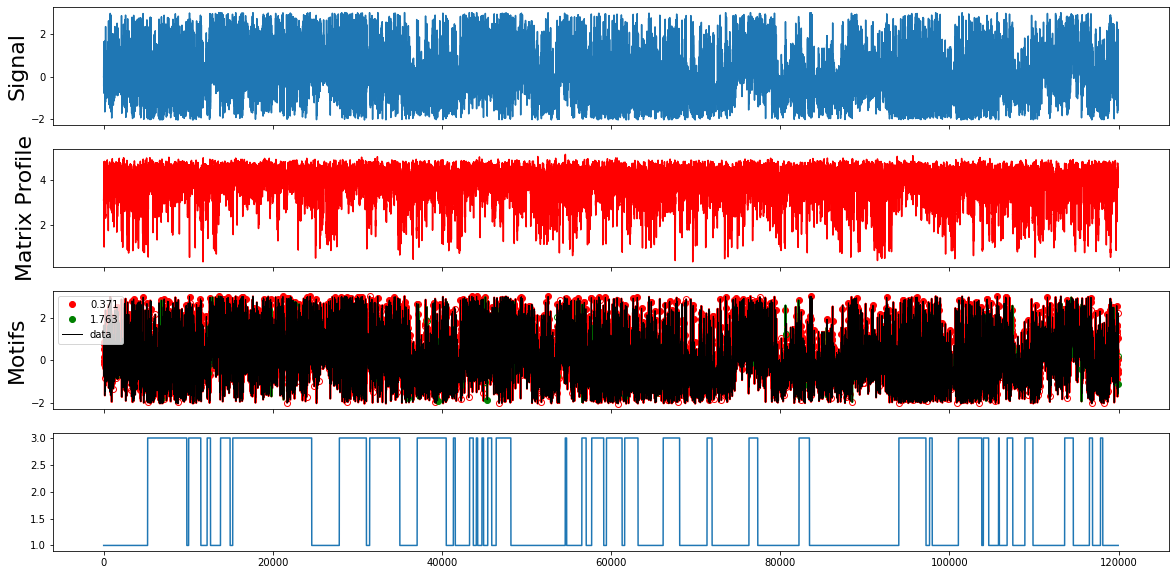

[[13, 37, 63, 88, 114, 140, 160, 193, 211, 229, 247, 264, 288, 306, 325, 342, 364, 382, 400, 417, 443, 468, 488, 515, 535, 560, 582, 599, 616, 639, 658, 685, 702, 728, 752, 771, 800, 830, 850, 876, 900, 919, 943, 961, 989, 1019, 1045, 1067, 1086, 1110, 1127, 1148, 1168, 1185, 1208, 1238, 1255, 1272, 1305, 1326, 1348, 1365, 1396, 1419, 1437, 1457, 1479, 1498, 1532, 1550, 1582, 1615, 1635, 1654, 1671, 1692, 1712, 1731, 1754, 1777, 1799, 1818, 1838, 1858, 1875, 1896, 1913, 1941, 1959, 1983, 2004, 2021, 2043, 2070, 2092, 2109, 2128, 2146, 2163, 2185, 2202, 2239, 2259, 2280, 2307, 2326, 2347, 2368, 2385, 2407, 2430, 2447, 2476, 2503, 2520, 2544, 2561, 2588, 2610, 2628, 2658, 2678, 2699, 2731, 2756, 2789, 2806, 2836, 2855, 2872, 2904, 2938, 2955, 2980, 3008, 3026, 3058, 3079, 3096, 3122, 3155, 3178, 3210, 3227, 3245, 3262, 3293, 3317, 3338, 3355, 3388, 3405, 3431, 3448, 3466, 3486, 3507, 3525, 3549, 3569, 3596, 3629, 3647, 3665, 3682, 3701, 3723, 3744, 3763, 3781, 3801, 3819, 3850, 3877, 389

In [38]:
# Other Motif Discovery library
# https://github.com/target/matrixprofile-ts/blob/master/docs/examples/Motif%20Discovery.ipynb

#TODO: in Feature extraction functrion packen und dann hyper param optimierung laufen lassen
print(data.shape)
from matrixprofile import *

#print([method_name for method_name in dir(matrixProfile)
#                  if callable(getattr(matrixProfile, method_name))])
pattern = data['acceleration_abs'].values#[:15000]
m = 32 #6
mp = matrixProfile.scrimp_plus_plus(pattern,m)
mtfs, motif_d  = motifs.motifs(pattern, mp, max_motifs=2, radius=23)#23

def plot_motifs(mtfs, labels, ax):
    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

#Append np.nan to Matrix profile to enable plotting against raw data
mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

#Plot the signal data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,sharex=True,figsize=(20,10))
ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
ax1.set_ylabel('Signal', size=22)

#Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)

#Plot the Motifs
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3)
ax3.set_ylabel('Motifs', size=22)
#plt.xlim((0,100))

ax4.plot(data['road_label'].values)#[:15000])
plt.show()

print(mtfs)

In [39]:
#engineer features from motifs by using attribute vectors
sz = len([item for sublist in mtfs for item in sublist])*m
attr_vec = np.ndarray(shape=(sz,3), dtype=float)
print(mtfs)
count = 0
i = 1.0
for motif in mtfs:
    for index in motif:
        elem = np.array(data[['acceleration_abs', 'road_label']].values[index:index+m])
        for pos, x in enumerate(elem):
            attr_vec[count+pos][0] = x[0]
            attr_vec[count+pos][1] = i 
            attr_vec[count+pos][2] = x[1]
            
        count+=m
    i+=1.0
#print(attr_vec)
X_train=attr_vec.transpose()[:2].transpose()#[500:800]
y_train=attr_vec.transpose()[2]#[500:800]
print(X_train.shape)
X_train = pandas.DataFrame(X_train)
y_train = pandas.DataFrame(y_train)

[[13, 37, 63, 88, 114, 140, 160, 193, 211, 229, 247, 264, 288, 306, 325, 342, 364, 382, 400, 417, 443, 468, 488, 515, 535, 560, 582, 599, 616, 639, 658, 685, 702, 728, 752, 771, 800, 830, 850, 876, 900, 919, 943, 961, 989, 1019, 1045, 1067, 1086, 1110, 1127, 1148, 1168, 1185, 1208, 1238, 1255, 1272, 1305, 1326, 1348, 1365, 1396, 1419, 1437, 1457, 1479, 1498, 1532, 1550, 1582, 1615, 1635, 1654, 1671, 1692, 1712, 1731, 1754, 1777, 1799, 1818, 1838, 1858, 1875, 1896, 1913, 1941, 1959, 1983, 2004, 2021, 2043, 2070, 2092, 2109, 2128, 2146, 2163, 2185, 2202, 2239, 2259, 2280, 2307, 2326, 2347, 2368, 2385, 2407, 2430, 2447, 2476, 2503, 2520, 2544, 2561, 2588, 2610, 2628, 2658, 2678, 2699, 2731, 2756, 2789, 2806, 2836, 2855, 2872, 2904, 2938, 2955, 2980, 3008, 3026, 3058, 3079, 3096, 3122, 3155, 3178, 3210, 3227, 3245, 3262, 3293, 3317, 3338, 3355, 3388, 3405, 3431, 3448, 3466, 3486, 3507, 3525, 3549, 3569, 3596, 3629, 3647, 3665, 3682, 3701, 3723, 3744, 3763, 3781, 3801, 3819, 3850, 3877, 389

(174496, 2)


In [40]:
#print(y_train)
print(list(y_train[0]).count(1.0)/len(y_train[0]))
np.savetxt(r'./X_Train.txt', X_train.values, fmt='%1.6f')
np.savetxt(r'./y_Train.txt', y_train.values, fmt='%1.6f')

0.578867137355584


In [44]:
#Test SVC on motif discovery
from sklearn.metrics import confusion_matrix

print('------------------Sklearn-----------------')
model = sklearn_factory.create_model(
    model_type = 'svc',
    X = X_train, 
    y = y_train, 
    model_params = {
        'kernel': ['rbf', 'linear','poly'],
        'degree': sp_randint(2, X_train.shape[1]*3),
        'gamma': np.concatenate((10.0 ** -np.arange(0, 10),10.0 ** np.arange(1, 10))),
        'C': sp_randint(2, 5000),
        'max_iter' : sp_randint(2, 5000),
        'shrinking' : [True, False],
        'probability' : [True, False],
        'random_state': sp_randint(1, 10),
    },
    search_params = [-1, 0, 10, 250, True, "svc_rs.pickle", 0.2]
    )
print('------------------SVC-----------------')
X_test, y_test = model['X_test'], model['y_test']
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")


model = sklearn_factory.create_model(
    model_type = 'random_forrest',
    X = X_train, 
    y = y_train,
    model_params = {
        'n_estimators' : sp_randint(1, 100),
        'max_depth': sp_randint(1, 128),
        #'max_features': sp_randint(1, X_train.shape[1]),
        'min_samples_split': sp_randint(2, X_train.shape[1]),
        'bootstrap': [True, False],
        "criterion": ["gini", "entropy"],
        'random_state': sp_randint(1, 10),
        'min_samples_split': sp_randint(2, 10)
    },
    search_params = [-1, 0, 10, 250, True, "rf_rs.pickle", 0.2]
    )
print('------------------Random Forrest----------------')
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")

------------------Sklearn-----------------


/home/lorenz/miniconda3/envs/rctc/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lorenz/miniconda3/envs/rctc/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lorenz/miniconda3/envs/rctc/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=3353).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


------------------SVC-----------------
0.5797134670487106
[[20135    67]
 [14601    97]]





/home/lorenz/miniconda3/envs/rctc/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/lorenz/miniconda3/envs/rctc/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


------------------Random Forrest----------------
0.9483094555873925
[[19315   887]
 [  917 13781]]





In [70]:
#Store in correct format for Sequitur motif discovery
motif_data=data.reindex(columns=['road_label', 
                                 #'acceleration_abs',
                                 #'acceleration_abs_2'
                                 #'acceleration_x', 'acceleration_y', 'acceleration_z',
                                 #'a', 'b', 'c', 'd', 'e', 'f',
                                 #'gravity_x', 'gravity_y', 'gravity_z',
                                 #'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
                                 'l_acceleration_x', 'l_acceleration_y', 'l_acceleration_z',
                    
                                ]).astype('float') #'acceleration_abs'
motif_data['road_label']=motif_data['road_label'].astype('int') 

motif_data = preprocessor.remove_nans(motif_data, replacement_mode='del_row')
test_sz = 0.1
#print(motif_data)
print(list(motif_data['road_label']).count(1.0)/len(motif_data))
print(list(motif_data['road_label']).count(3.0)/len(motif_data))

motif_data_test = motif_data.head(int(len(motif_data)*test_sz))
motif_data_train = motif_data.tail(len(motif_data)-int(len(motif_data)*test_sz))
print(motif_data_test.shape)
print(motif_data_train.shape)
print(list(motif_data_train['road_label']).count(1.0)/len(motif_data_train))
print(list(motif_data_train['road_label']).count(3.0)/len(motif_data_train))
print(list(motif_data_test['road_label']).count(1.0)/len(motif_data_test))
print(list(motif_data_test['road_label']).count(3.0)/len(motif_data_test))

#np.savetxt(r'./motif_data_test.txt', motif_data_test.values, fmt='%1.6f')
#np.savetxt(r'./motif_data_train.txt', motif_data_train.values, fmt='%1.6f')


gc.collect()
#print(motif_data_test)

#motif_data_train_small = motif_data.tail(int(len(motif_data)*0.5)-int(len(motif_data)*test_sz*0.5))
#motif_data_test_small = motif_data.head(int(len(motif_data)*test_sz*0.5))
#print(motif_data_test_small.shape)
#print(motif_data_train_small.shape)
#print(list(motif_data_train_small['road_label']).count(1.0)/len(motif_data_train_small))
#print(list(motif_data_train_small['road_label']).count(3.0)/len(motif_data_train_small))
#print(list(motif_data_test_small['road_label']).count(1.0)/len(motif_data_test_small))
#print(list(motif_data_test_small['road_label']).count(3.0)/len(motif_data_test_small))

#print(motif_data_test_small)
#np.savetxt(r'./motif_data_test_small.txt', motif_data_test_small.values, fmt='%1.4f')
#np.savetxt(r'./motif_data_train_small.txt', motif_data_train_small.values, fmt='%1.4f')
#np.savetxt(r'./X_Train.txt', motif_data_train['acceleration_abs'].values, fmt='%1.4f')

ZeroDivisionError: division by zero

In [ ]:
# Visual anlaysis of the segments:
#sns.set(rc={'figure.figsize':(15, 4)})
#fig, ax = plt.subplots(figsize=(15,4*len(data_segments)), ncols=1, nrows=len(data_segments)+1)
#for ind in range(len(data_segments)): 
#    sns.lineplot(y='acceleration_abs', x='time', data = data_segments[ind], ax=ax[ind])
#    ax[ind].legend("Road" if data_segments[ind]['road_label'].iloc[0] < 2.0 else "City" )
    

In [ ]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=motif_data_train[['acceleration_abs', 'road_label']])

In [ ]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=motif_data_train[['l_acceleration_y', 'road_label']])

In [ ]:
# 3. Feature Extraction
# 3.1 Encode categorical to binary
data = preprocessor.encode_categorical_features(data = data, 
                                                mode = 'custom_function', 
                                                columns = ['road_label'],
                                                encoding_function = lambda x :  (x  > 2.0).astype(int)
                                               ) #0 City, 1 Countryside

# 3.2
# Generate label vector y and feature matrix X.
# We need at least 2 classes to learn features for tsfresh
y = data[['road_label']].reset_index(drop=True)
data['id'] = range(1, len(data) + 1)
y['id'] = data['id']
y['road_label'].index=list(y['id'])

# 3.3 Extract feature matrix
# Read https://github.com/blue-yonder/tsfresh/issues/444 for info about the warnings
X = extractor.extract_features(data = data, args = ['id', y['road_label'], 32, None, 0.1])

In [ ]:
#3.3.1 Read/Write extracted features
#dao.write_features('./data_sets/X.pkl', X)
#dao.write_features('./data_sets/y.pkl', y)
X = dao.load_features('./data_sets/X.pkl')
y = dao.load_features('./data_sets/y.pkl')
print(len(y))
keys = X.keys()
keys = list(filter(lambda x: "acceleration_abs" in x, keys))
print(X.shape)
#print(y)
print(list(y['road_label']).count(0)/len(y))

In [ ]:
# 3.4 combine feature rows
X_join = pandas.concat([X, y], axis=1)
X_join = preprocessor.remove_nans(X_join, replacement_mode='del_row')
X_join[['road_label']] = X_join[['road_label']].astype('int')
X_segments = preprocessor.segment_data(X_join, mode='labels', 
                                    label_column='road_label', 
                                    args=[0,1])


segment_length = 30 #60s best in paper, 90 best in my evaluation, tested 30, 60, 90, 120
X_segments_new = []
for ind in range(0, len(X_segments)):
    X_segments_new = X_segments_new + preprocessor.segment_data(
        X_segments[ind],
        mode = 'fixed_interval', 
        args = [segment_length, True, True]
    )
    
    
print(len(X_segments_new))
keys.append('road_label')
X_combined = preprocessor.de_segment_data(X_segments_new, keys)
X_combined, y_combined = X_combined[keys[:-1]], X_combined[keys[-1]]

In [ ]:
#import matplotlib.pyplot as plt
#X_combined.hist(figsize=(15,15)) #check ditrsibution -> normal

In [ ]:
#plt.figure(figsize=(10,10))
#plt.matshow(X_combined.corr(), fignum=1)

In [ ]:
#plt.figure(figsize=(10,10))
#plt.matshow(X_combined.cov(), fignum=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# 3.5 Read/Write combined features
#print(type(y_combined))
dao.write_features('./data_sets/X_combined.pkl', X_combined)
dao.write_features('./data_sets/y_combined.pkl', y_combined)
# 3.6  extracted features
X_combined = dao.load_features('./data_sets/X_combined.pkl')
y_combined = dao.load_features('./data_sets/y_combined.pkl')

print(X_combined.shape)
print(list(y_combined).count(0)/len(y_combined))
  
y_clustering = IsolationForest(behaviour='new', 
                               max_samples=5, 
                               n_jobs=-1, 
                               contamination=0.25,
                               max_features=1.0,
                               n_estimators=750
                              ).fit_predict(X_combined)

X_combined = X_combined.loc[pandas.DataFrame(y_clustering)[0] == 1]
y_combined = y_combined.loc[pandas.DataFrame(y_clustering)[0] == 1]

print(X_combined.shape)
print(list(y_combined).count(0)/len(y_combined))

X_combined = X_combined.reset_index(drop=True)
y_combined = y_combined.reset_index(drop=True)



#X_combined.hist(figsize=(15,15)) #check ditrsibution -> normal

In [ ]:
#Tried but failed improvbement methods
#1
#https://en.wikipedia.org/wiki/Feature_selection#Correlation_feature_selection
#X_combined = X_combined[X_combined.columns[[0,1,3,20,21,22]]
# Didnt help

# Preclustering using DBSCAN, Optics and KMeans (last on normalized Dataset) and adding prediciton 
# as new feature made results worse.

X_train, X_validation, y_train, y_validation = train_test_split(X_combined,
                                                    y_combined,
                                                    test_size=0.3,
                                                    stratify=y_combined
                                                    )


In [ ]:
# 4.1 Produce models from a given hyper parameter search space
#TODO: Put model types and parametzer and search spaces into config.
from sklearn.metrics import confusion_matrix

print('------------------Sklearn-----------------')
model = sklearn_factory.create_model(
    model_type = 'svc',
    X = X_train, 
    y = y_train, 
    model_params = {
        'kernel': ['rbf', 'linear','poly'],
        'degree': sp_randint(2, X_combined.shape[1]*3),
        'gamma': np.concatenate((10.0 ** -np.arange(0, 10),10.0 ** np.arange(1, 10))),
        'C': sp_randint(2, 5000),
        'max_iter' : sp_randint(2, 5000),
        'shrinking' : [True, False],
        'probability' : [True, False],
        'random_state': sp_randint(1, 10),
    },
    search_params = [-1, 0, 10, 2500, True, "svc_rs.pickle", 0.2]
    )
print('------------------SVC-----------------')
X_test, y_test = model['X_test'], model['y_test']
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")

model = sklearn_factory.create_model(
    model_type = 'cart_tree',
    X = X_train, 
    y = y_train, 
    model_params = {
        "max_depth": sp_randint(1, 128),
        "max_features": sp_randint(1, X_combined.shape[1]),
        "min_samples_leaf": sp_randint(1, X_combined.shape[1]),
        "criterion": ["gini", "entropy"],
        'random_state': sp_randint(1, 10),
        'splitter' : ['best', 'random'],
        'min_samples_split': sp_randint(2, 10)
    },
    search_params = [-1, 0, 10, 2500, True, "dt_rs.pickle", 0.2]
    )
print('------------------CART-Tree-----------------')
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")

model = sklearn_factory.create_model(
    model_type = 'random_forrest',
    X = X_train, 
    y = y_train,
    model_params = {
        'n_estimators' : sp_randint(1, 100),
        'max_depth': sp_randint(1, 128),
        'max_features': sp_randint(1, X_combined.shape[1]),
        'min_samples_split': sp_randint(2, X_combined.shape[1]),
        'bootstrap': [True, False],
        "criterion": ["gini", "entropy"],
        'random_state': sp_randint(1, 10),
        'min_samples_split': sp_randint(2, 10)
    },
    search_params = [-1, 0, 10, 2500, True, "rf_rs.pickle", 0.2]
    )
print('------------------Random Forrest----------------')
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")

model = sklearn_factory.create_model(
    model_type = 'mlp_classifier',
    X = X_train, 
    y = y_train, 
    model_params = {
        'solver': ['adam', 'lbfgs', 'sgd'], 
        'max_iter': sp_randint(1, 250), 
        'alpha': np.concatenate((10.0 ** -np.arange(0, 10),10.0 ** np.arange(1, 10))), 
        'hidden_layer_sizes':[(128,128,128,128), #architecture see
                              (128,128,128),
                              (128,128),
                              (128),
                              (64,64,64,64),
                              (64,64,64),
                              (64,64),
                              (64),
                              (32,32,32,32),
                              (32,32,32),
                              (32,32),
                              (32),
                              (16,16,16,16),
                              (16,16,16),
                              (16,16),
                              (16)
                             ], 
        'random_state': sp_randint(1, 10),
        'activation': ["logistic", "relu", "tanh"],
        'learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init' : np.concatenate((10.0 ** -np.arange(0, 10),10.0 ** np.arange(1, 10))),
        'batch_size' : sp_randint(1, 10),
        'shuffle' :[True, False],
        'early_stopping' : [True, False],
    },
    search_params = [-1, 0, 10, 100, True, "mlp_rs.pickle", 0.2]
    )
print('------------------MLP----------------')
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")


model = tslearn_factory.create_model(
    model_type = 'tssvc',
    X = X_train, 
    y = y_train,
    model_params = {
        'kernel': ['rbf', 'linear','poly', 'gak'],
        'degree': sp_randint(2, X_combined.shape[1]*3),
        'gamma': np.concatenate((10.0 ** -np.arange(0, 5),10.0 ** np.arange(1, 10))),
        'max_iter' : sp_randint(2, 5000),
        'shrinking' : [True, False],
        'probability' : [True, False],
        'random_state': sp_randint(1, 10),
    },
    search_params = [32, 0, 10, 250, True, "tssv_rs.pickle", 0.2]
    )

print('------------------Tslearn-----------------')
print('------------------TSSVC----------------')
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")

model = tslearn_factory.create_model(
    model_type = 'knn_classifier',
    X = X_train, 
    y = y_train, 
    model_params = {
        'n_neighbors' : sp_randint(2, X_combined.shape[1]*2),
        'metric' : ['dtw', 'softdtw', 'euclidean', 'sqeuclidean', 'cityblock']
    },
    search_params = [32, 0, 10, 250, True, "tsknn_rs.pickle", 0.2]
    )
print('------------------KNNC----------------')
print(model['clf'].score(X_test, y_test))
y_pred = model['clf'].predict(X_test)
conf = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(conf)
print("\n\n")


In [ ]:
from sklearn.metrics import classification_report

#Evaluate best model using validation set
print('Testset:')
print('Shape: '+str(X_test.shape))
print('% class 0 (City)'+str(list(y_test).count(0)/len(y_test)))
print('\n')
print('Validationset:')
print('Shape: '+str(X_validation.shape))
print('% class 0 (City)'+str(list(y_validation).count(0)/len(y_validation)))
print('\n')

print("----------------sklearn----------------")
print("MLP")
with open('mlp_rs.pickle', 'rb') as f:
    clf = pickle.load(f)
print('Score on Testset: '+str(clf.score(X_test, y_test)))
print('Report for Validationset:')
print(str(classification_report(y_validation, clf.predict(X_validation))))
print(clf.best_params_)
print("\n\n")

print("CART Tree")
with open('dt_rs.pickle', 'rb') as f:
    clf = pickle.load(f)
print('Score on Testset: '+str(clf.score(X_test, y_test)))
print('Report for Validationset:')
print(str(classification_report(y_validation, clf.predict(X_validation))))
print(clf.best_params_)
print("\n\n")

print("Random Forrest")
with open('rf_rs.pickle', 'rb') as f:
    clf = pickle.load(f)
print('Score on Testset: '+str(clf.score(X_test, y_test)))
print('Report for Validationset:')
print(str(classification_report(y_validation, clf.predict(X_validation))))
print(clf.best_params_)
print("\n\n")

print("SVC")
with open('svc_rs.pickle', 'rb') as f:
    clf = pickle.load(f)
print('Score on Testset: '+str(clf.score(X_test, y_test)))
print('Report for Validationset:')
print(str(classification_report(y_validation, clf.predict(X_validation))))
print(clf.best_params_)
print("\n\n")

print("----------------tslearn----------------")
print("TSSVC")
with open('tssv_rs.pickle', 'rb') as f:
    clf = pickle.load(f)
print('Score on Testset: '+str(clf.score(X_test, y_test)))
print('Report for Validationset:')
print(str(classification_report(y_validation, clf.predict(X_validation))))
print(clf.best_params_)
print("\n\n")

print("TSKNN")
with open('tsknn_rs.pickle', 'rb') as f:
    clf = pickle.load(f)
print('Score on Testset: '+str(clf.score(X_test, y_test)))
print('Report for Validationset:')
print(str(classification_report(y_validation, clf.predict(X_validation))))
print(clf.best_params_)
print("\n\n")